<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist-m.xlsx')
# df=pd.read_excel('unisim_hist-m.xlsx').iloc[:66,:]
df.tail()

,Date,Press,Np,Gp,Wp,Winj
128,2024-01-31,305,24757936,2793256452,4393983,36864922
129,2024-02-29,306,25022300,2822363056,4583991,37475894
130,2024-03-31,307,25304090,2853787229,4789676,38123794
131,2024-04-30,308,25567400,2883725639,4991816,38702374
132,2024-05-31,309,25832419,2913898931,5206739,39341191


In [2]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 0.000162
cw = 47.6E-06
Swi = 0.17 ** 0.35

In [3]:
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
df["dp"]= df["Press"].iloc[0]-df["Press"]
df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.head()

,Date,Press,Np,Gp,Wp,Winj,Rp,t,dt,p_med,dp,pmt
0,2013-05-31,332,0,0,0,0,0.000000,0.0,0.0,332.0,0,0.0
1,2013-06-30,332,0,0,0,0,0.000000,30.0,30.0,332.0,0,0.0
2,2013-07-31,331,61938,6858068,0,0,110.724725,61.0,31.0,331.5,1,15.5
3,2013-08-31,329,124403,13532213,0,0,108.777224,92.0,31.0,330.0,3,77.5
4,2013-09-30,328,182423,20112443,0,0,110.251684,122.0,30.0,328.5,4,182.5


In [4]:
## PVT functions

def func_bo(p, a, b):
    bo1 = a*p[p<pb]+b
    bo2 = bob+co*bob*(pb-p[p>=pb])
    return np.append(bo1, bo2)

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs1 = a*p[p<pb]+b
    rs2 = Rsi*np.ones(len(p[p>=pb]))
    return np.append(rs1, rs2)

In [5]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs

df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*df["dp"]

df.head()

,Date,Press,Np,Gp,Wp,Winj,Rp,t,dt,p_med,dp,pmt,Bo,Bg,Rs,Bt,F,Eo,Eg,Efw
0,2013-05-31,332,0,0,0,0,0.000000,0.0,0.0,332.0,0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332,0,0,0,0,0.000000,30.0,30.0,332.0,0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,110.724725,61.0,31.0,331.5,1,15.5,1.386290,0.003325,113.06,1.386290,85383.031591,0.000229,0.004365,0.000236
3,2013-08-31,329,124403,13532213,0,0,108.777224,92.0,31.0,330.0,3,77.5,1.386748,0.003346,113.06,1.386748,170732.679461,0.000687,0.013176,0.000707
4,2013-09-30,328,182423,20112443,0,0,110.251684,122.0,30.0,328.5,4,182.5,1.386977,0.003357,113.06,1.386977,251296.687673,0.000916,0.017623,0.000943


In [6]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
dp=train["dp"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values
pmt=train["pmt"].values
p_med=train["p_med"].values

Estimativa de N: 100251299.71893016
Estimativa de Wei: 3845697.307193065
Estimativas de J: 403.1216826448983
0.9811318211031446


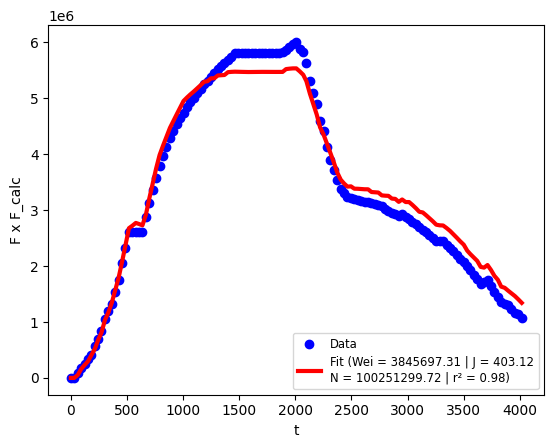

In [7]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, F, m):
    N = x[0]  # N é constante
    Wei = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
      pa_med[i]=p[0]*(1-(Wen[i-1]/Wei))
    F_calc = N * (Eo + m * Eg + (1 + m) * Efw) + Wen
    return np.sum((F - F_calc) ** 2)

# Chute inicial para N, Wei e J
x0 = np.array([10**8] + [10**5] + [1])

# Limites para N, Wei e J
bounds = [(0.1, None)] + [(0.1, None)] + [(0.1, 10**3)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, F, m), bounds=bounds)

N_est = result.x[0]
Wei_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est}")
print(f"Estimativa de Wei: {Wei_est}")
print(f"Estimativas de J: {J_est}")

Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
  pa_med[i] = p[0]*(1-(Wen[i-1]/Wei_est))

# print(pa_med)

F_calc = N_est * (Eo + m * Eg + (1 + m) * Efw) + Wen
r2_2 = r2_score(F, F_calc)
print(r2_2)

plt.scatter(t, F, label="Data", color="blue")
plt.plot(t, F_calc, label=f"Fit (Wei = {Wei_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("F x F_calc")
plt.show()

<ipython-input-14-3c60eed1b91f>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_med[i]=(p_prev[i-1]+pn)/2


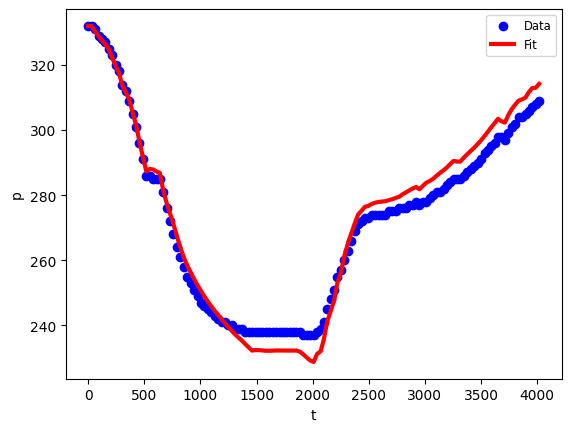

In [ ]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We
## We = F-N*(Eo+mEg+(1+m)Efw)
## Previsão

p_prev=np.zeros(len(t))
we_prev=np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
p_prev = np.zeros(len(t))
p_med = np.zeros(len(t))

def f_fet(pn, i):
    p_med[i]=(p_prev[i-1]+pn)/2
    # print(p_med[i])
    we_prev[i] = we_prev[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p_med[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
    pa_med[i] = p[0]*(1-(we_prev[i-1]/Wei_est))
    # print(we_prev[i])
    return we_prev[i]

def f_ebm(pn, i):
    Bo=bob+co*bob*(pb-pn)
    Bg=1.40676*pn**(-1.04229)
    F=npp[i]*(Bo+(rp[i]-Rsi)*Bg)+(wp[i]-winj[i])*Bw
    Eo=Bo-bo[0]
    Eg=bo[0]*(Bg/bg[0]-1)
    Efw=bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
    EBM=F-N_est*(Eo+m*Eg+(1+m)*Efw)
    # print(EBM)
    return EBM

for i in range(len(t)):
    if i == 0:
        p_prev[i]=p[0]
        we_prev[i]=0
        pa_med[0]=p[0]
    else:
        pn=p_prev[i-1]
        def f_obj(pn):
            Aquif=f_fet(pn, i)
            EBM=f_ebm(pn, i)
            return(EBM-Aquif)
        result=f_obj(pn)
        const = {'type':'eq', 'fun': f_obj}
        result=minimize(f_obj, pn, constraints=const)
        p_prev[i]=result.x[0]

plt.scatter(t, p, label="Data", color="blue")
plt.plot(t, p_prev, label="Fit", color="red", linewidth=3)
# plt.plot(t, df["Press_b"], label="Benchmark", color="black", linewidth=2, linestyle='--')
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p")
plt.show()

In [ ]:
date=df["Date"].values
date_time=pd.to_datetime(date)
date_time

DatetimeIndex(['2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', length=133, freq=None)

In [ ]:
from pandas.tseries.offsets import MonthEnd

# Última data fornecida
last_date = date_time[-1]

# Gerar 24 novas datas, no último dia de cada mês seguinte
new_dates = pd.to_datetime([last_date + MonthEnd(n) for n in range(1, 25)])
new_dates

# (new_dates[0]-date_time[-1]).days

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31',
               '2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30',
               '2025-10-31', '2025-11-30', '2025-12-31', '2026-01-31',
               '2026-02-28', '2026-03-31', '2026-04-30', '2026-05-31'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
## Forecast

fc = pd.DataFrame(new_dates, columns=['Date'])
fc = pd.concat([df, fc], ignore_index=True).iloc[:,:].fillna(0)
fc

,Date,Press,Np,Gp,Wp,Winj,Rp,t,dt,p_med,dp,pmt,Bo,Bg,Rs,Bt,F,Eo,Eg,Efw
0,2013-05-31,332.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,332.0,0.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332.0,0.0,0.0,0.0,0.0,0.000000,30.0,30.0,332.0,0.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331.0,61938.0,6858068.0,0.0,0.0,110.724725,61.0,31.0,331.5,1.0,15.5,1.386290,0.003325,113.06,1.386290,85383.031591,0.000229,0.004365,0.000236
3,2013-08-31,329.0,124403.0,13532213.0,0.0,0.0,108.777224,92.0,31.0,330.0,3.0,77.5,1.386748,0.003346,113.06,1.386748,170732.679461,0.000687,0.013176,0.000707
4,2013-09-30,328.0,182423.0,20112443.0,0.0,0.0,110.251684,122.0,30.0,328.5,4.0,182.5,1.386977,0.003357,113.06,1.386977,251296.687673,0.000916,0.017623,0.000943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2026-01-31,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
153,2026-02-28,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
154,2026-03-31,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
155,2026-04-30,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
fc.iloc[-1, 1] = "Novo valor"
fc

,Date,Press,Np,Gp,Wp,Winj,Rp,t,dt,p_med,dp,pmt,Bo,Bg,Rs,Bt,F,Eo,Eg,Efw
0,2013-05-31,332.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,332.0,0.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
1,2013-06-30,332.0,0.0,0.0,0.0,0.0,0.000000,30.0,30.0,332.0,0.0,0.0,1.386061,0.003315,113.06,1.386061,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331.0,61938.0,6858068.0,0.0,0.0,110.724725,61.0,31.0,331.5,1.0,15.5,1.386290,0.003325,113.06,1.386290,85383.031591,0.000229,0.004365,0.000236
3,2013-08-31,329.0,124403.0,13532213.0,0.0,0.0,108.777224,92.0,31.0,330.0,3.0,77.5,1.386748,0.003346,113.06,1.386748,170732.679461,0.000687,0.013176,0.000707
4,2013-09-30,328.0,182423.0,20112443.0,0.0,0.0,110.251684,122.0,30.0,328.5,4.0,182.5,1.386977,0.003357,113.06,1.386977,251296.687673,0.000916,0.017623,0.000943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2026-01-31,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
153,2026-02-28,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
154,2026-03-31,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
155,2026-04-30,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
